In [71]:
import numpy as np
import torch
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
current_date = '100912-101000'

In [4]:
EXCHANGE = {
        'bitfinex':{
            'pair': 'BTCUSD',
			'period': ""
			},
		'binance':{
			'pair': 'BTCUSDT',
			'period': ""
			},
		'okex_spot_v3':{
			'pair': 'BTCUSDT',
			'period': ""
			},
		'huobipro':{
			'pair': 'BTCUSDT',
			'period': ""
			},
		'okex_future_v3':{
			'pair': 'BTCUSD',
			'period': "Q"
			},
		'huobidm':{
			'pair': 'BTCUSD',
			'period': "Q"
			},
		'bitmex':{
			'pair': 'BTCUSD',
			'period': "P"
			}
		}

In [5]:
excel_file_input = pd.ExcelFile('/Users/dear/Desktop/Pythagoras/1014/imbalance&return.xlsx')

In [47]:
input_list = []

In [50]:
for ex in EXCHANGE:
	input_ex = pd.read_excel(excel_file_input, ex).dropna(how='any')
	input_list.append([i[0] for i in StandardScaler().fit_transform(input_ex.loc[:, ['average imbalance']].values)])
	input_list.append([i[0] for i in StandardScaler().fit_transform(input_ex.loc[:, ['order imbalance ratio']].values)])
	input_list.append([i[0] for i in StandardScaler().fit_transform(input_ex.loc[:, ['net trade size']].values)])
	input_list.append([i[0] for i in StandardScaler().fit_transform(input_ex.loc[:, ['depth imbalance']].values)])

In [52]:
huobidm_input = pd.read_excel(excel_file_input, 'huobidm').dropna(how='any')
inputs = np.array([list(a) for a in tuple(zip(*input_list))][:int(len(input_list[0])*0.5)], dtype='float32')
targets = np.array(list(huobidm_input['return10'])[:int(len(input_list[0])*0.5)], dtype='float32')
inputs = torch.from_numpy(inputs)
targets = torch.unsqueeze(torch.from_numpy(targets), dim =1)

In [53]:
batch_size = 5000
input_size = 28
hidden_size = 10
output_size = 1

In [54]:
train_ds = TensorDataset(inputs, targets)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [55]:
model = torch.nn.Sequential(
	torch.nn.Linear(input_size,hidden_size),
	torch.nn.Sigmoid(),
	torch.nn.Linear(hidden_size,output_size)
	)

In [60]:
# 定义优化器
opt = torch.optim.SGD(model.parameters(), lr = 0.1)

In [61]:
# 定义损失函数
loss_fn = F.mse_loss
loss = loss_fn(model(inputs), targets)

In [62]:
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
        	# Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
        if epoch % 10 == 0:
        	print('Training loss: ', loss)

In [63]:
fit(1000, model, loss_fn, opt)

Training loss:  tensor(0.0020, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0013, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0010, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0008, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0006, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0005, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0004, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0003, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0003, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0002, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0002, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0002, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0002, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0001, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0001, grad_fn=<MseLossBackward>)
Training loss:  tensor(0.0001, grad_fn=<MseLossBackward>)
Training loss:  tensor(9.1306e-05, grad_fn=<MseLossBackward>)
Training l

In [64]:
inputs_out = np.array([list(a) for a in tuple(zip(*input_list))][int(len(input_list[0])*0.5):], dtype='float32')
inputs_out = torch.from_numpy(inputs_out)
preds = list(model(inputs_out).cpu().detach().numpy())
targets = np.array(list(huobidm_input['return10'])[int(len(input_list[0])*0.5):], dtype='float32')

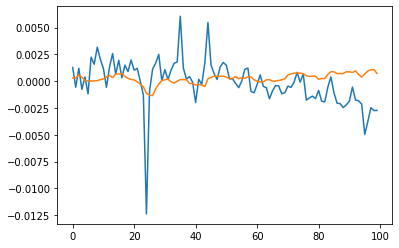

In [77]:
plt.plot(preds[100:200])
plt.plot(targets[100:200])